# SVM Demo with the Semiconductor Dataset
This Jupyter Notebook is used internally for demonstrating Support Vector Machines in R, using the SECOM dataset.

For questions, please contact me at: Marcel van den Bosch <marcel.vandenbosch@atos.net>

In [251]:
set.seed(1234)

### Change Jupyter Notebook plot size settings

In [1]:
options(repr.plot.width=6, repr.plot.height=6,repr.plot.pointsize=8, repr.plot.res = 90)

### Load required packages

In [224]:
library(e1071)
library(caret)
library(caTools)
library(data.table)
library(DMwR)

Loading required package: grid


### Get required dataset
Quickly retrieve the SECOM dataset from my github page. Let's reuse a modified version of the load
function, used in the AtosInnovatos 2017 Shiny App.

In [3]:
loadData <- function()
{
  data <- read.csv(url('https://raw.githubusercontent.com/mvdbosch/AtosInnovatos2017/master/secom_dataset/secom.data'),
                   sep=' ',header=F);  
  names(data) <- paste0('MEAS_',rep(1:ncol(data)));  
  data.labels <- read.csv(url('https://raw.githubusercontent.com/mvdbosch/AtosInnovatos2017/master/secom_dataset/secom_labels.data'),
                   sep=' ',header=F);
  names(data.labels) <- c('FAIL','TIMESTAMP');
  
  data <- cbind(data.labels,data);  
  data$FAIL[data$FAIL == -1] <- 'OK';
  data$FAIL[data$FAIL == 1] <- 'FAIL';
  
  data$FAIL <- as.factor(data$FAIL);
  
  data$TIMESTAMP <- as.POSIXct(strptime(data$TIMESTAMP, "%d/%m/%Y %H:%M:%S"))
  
  return(data)
}

In [238]:
secom_data <- loadData()

### Inspect the Dataset
The SECOM dataset (McCann & Johnston, 2008).is publicly available data from a semi-conductor manufacturing process. 

The data consists of 2 files the dataset file SECOM consisting of 1567 examples each with 591 features a 1567 x 591 matrix and a labels file containing the classifications and date time stamp for each example

In [77]:
head(secom_data)

FAIL,TIMESTAMP,MEAS_1,MEAS_2,MEAS_3,MEAS_4,MEAS_5,MEAS_6,MEAS_7,MEAS_8,⋯,MEAS_581,MEAS_582,MEAS_583,MEAS_584,MEAS_585,MEAS_586,MEAS_587,MEAS_588,MEAS_589,MEAS_590
OK,2008-07-19 11:55:00,3030.93,2564.00,2187.733,1411.1265,1.3602,100,97.6133,0.1242,⋯,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
OK,2008-07-19 12:32:00,3095.78,2465.14,2230.422,1463.6606,0.8294,100,102.3433,0.1247,⋯,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
FAIL,2008-07-19 13:17:00,2932.61,2559.94,2186.411,1698.0172,1.5102,100,95.4878,0.1241,⋯,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
OK,2008-07-19 14:43:00,2988.72,2479.90,2199.033,909.7926,1.3204,100,104.2367,0.1217,⋯,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
OK,2008-07-19 15:22:00,3032.24,2502.87,2233.367,1326.5200,1.5334,100,100.3967,0.1235,⋯,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432
OK,2008-07-19 17:53:00,2946.25,2432.84,2233.367,1326.5200,1.5334,100,100.3967,0.1235,⋯,0.0052,44.0077,0.4949,0.0189,0.0044,3.8276,0.0342,0.0151,0.0052,44.0077


### Split into a test & training set

In [205]:
sample = sample.split(secom_data$FAIL, SplitRatio = .75)
secom.train = subset(copy(secom_data), sample == TRUE)
secom.test = subset(copy(secom_data), sample == FALSE)
cat("No. of samples in training set: ",nrow(secom.train),"\r\n")
cat("No. of samples in test set: ",nrow(secom.test))

No. of samples in training set:  1175 
No. of samples in test set:  392

### Build our first SVM model

In [206]:
secom.train <- subset(secom.train,select=-TIMESTAMP);

columns.to.keep<-names(which(colMeans(is.na(secom.train)) < 0.5)) # this removes those columns with more than 50% NULLs
secom.train<-subset(secom.train,select = columns.to.keep) #the columns will stay which has less than 50% NAs

nzv <- nearZeroVar(secom.train)
secom.train <- subset(secom.train, select = colnames(secom.train[,-nzv]))

Fit our SVM model

In [207]:
fit.svm <- svm(FAIL ~ .,data=secom.train)

In [208]:
summary(fit.svm)


Call:
svm(formula = FAIL ~ ., data = secom.train)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.002298851 

Number of Support Vectors:  218

 ( 28 190 )


Number of Classes:  2 

Levels: 
 FAIL OK




Work on our test set

In [209]:
secom.test[is.na(secom.test)] <--9999 # NA's will be omitted during prediction.
secom.test.label <- secom.test$FAIL; # Make sure we have the results seaprate - as some functions like it separate

In [210]:
secom.test <- subset(secom.test, select = setdiff(colnames(secom.train),'FAIL')) # Ensure same cols as training set

Perform the actual prediction

In [211]:
pred_data <- predict(object = fit.svm, newdata = secom.test)

Create a confusion matrix to evaluate the model performance

In [212]:
xtab <- table(pred_data, test_result)
confusionMatrix(xtab)

Confusion Matrix and Statistics

         test_result
pred_data FAIL  OK
     FAIL    0   0
     OK     26 366
                                          
               Accuracy : 0.9337          
                 95% CI : (0.9043, 0.9562)
    No Information Rate : 0.9337          
    P-Value [Acc > NIR] : 0.5519          
                                          
                  Kappa : 0               
 Mcnemar's Test P-Value : 9.443e-07       
                                          
            Sensitivity : 0.00000         
            Specificity : 1.00000         
         Pos Pred Value :     NaN         
         Neg Pred Value : 0.93367         
             Prevalence : 0.06633         
         Detection Rate : 0.00000         
   Detection Prevalence : 0.00000         
      Balanced Accuracy : 0.50000         
                                          
       'Positive' Class : FAIL            
                                          

### Evaluating the results of our first model
Looking at these results, we can conclude that this model does a very poor job in predicting the actual failures (i.e. the model always predicts no failure and gets a 93% accuracy!)

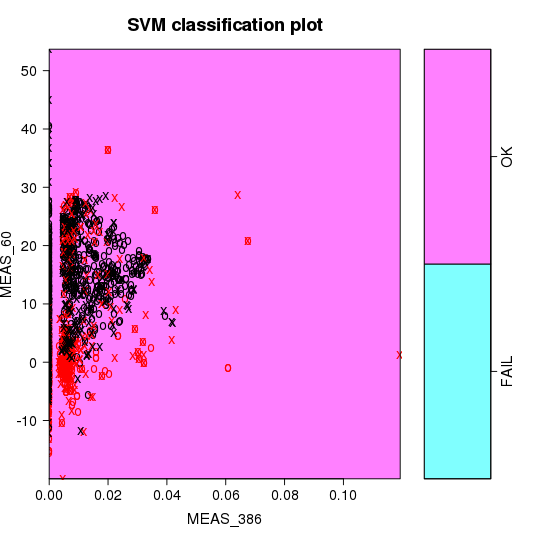

In [237]:
plot(fit.svm,data=secom.train,MEAS_60 ~ MEAS_386)

### Let's try to balance the classes a little bit with SMOTE

In [449]:
set.seed(1234)
sample = sample.split(secom_data$FAIL, SplitRatio = 0.75)
secom.train = subset(copy(secom_data), sample == TRUE)
secom.test = subset(copy(secom_data), sample == FALSE)
cat("No. of samples in training set: ",nrow(secom.train),"\r\n")
cat("No. of samples in test set: ",nrow(secom.test))

secom.train <- subset(secom.train,select=-TIMESTAMP);
secom.train <-SMOTE(form = FAIL ~., data = secom.train, perc.over = 600,perc.under = 100)

columns.to.keep<-names(which(colMeans(is.na(secom.train)) < 0.5)) # this removes those columns with more than 50% NULLs
secom.train<-subset(secom.train,select = columns.to.keep) #the columns will stay which has less than 50% NAs

nzv <- nearZeroVar(secom.train)
secom.train <- subset(secom.train, select = colnames(secom.train[,-nzv]))
secom.train[is.na(secom.train)] <-- 0

#######################################################
### Try with polynomial kernel
#######################################################
#fit.svm <- svm(FAIL ~ MEAS_60 +  MEAS_437 + MEAS_361 + MEAS_436 + MEAS_431 + MEAS_558 + MEAS_435, data=secom.train,
#              kernel = "polynomial",degree=2)

#######################################################
### Try with linear kernel
#######################################################

#fit.svm <- svm(FAIL ~ MEAS_60 +  MEAS_437 + MEAS_361 + MEAS_436 + MEAS_431 + MEAS_558 + MEAS_435, data=secom.train,
#              kernel = "linear")

#######################################################
### Try with default radial kernel
#######################################################
fit.svm <- svm(FAIL ~ MEAS_60 +  MEAS_437 + MEAS_361 + MEAS_436 + MEAS_431 + MEAS_558 + MEAS_435, data=secom.train)

secom.test[is.na(secom.test)] <--0 # NA's will be omitted during prediction.
secom.test.label <- secom.test$FAIL; # Make sure we have the results seaprate - as some functions like it separate

secom.test <- subset(secom.test, select = setdiff(colnames(secom.train),'FAIL')) # Ensure same cols as training set

pred_data <- predict(object = fit.svm, newdata = secom.test)

xtab <- table(pred_data, test_result)
confusionMatrix(xtab)

No. of samples in training set:  1175 
No. of samples in test set:  392

Confusion Matrix and Statistics

         test_result
pred_data FAIL  OK
     FAIL    8  54
     OK     18 312
                                          
               Accuracy : 0.8163          
                 95% CI : (0.7744, 0.8534)
    No Information Rate : 0.9337          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0975          
 Mcnemar's Test P-Value : 3.711e-05       
                                          
            Sensitivity : 0.30769         
            Specificity : 0.85246         
         Pos Pred Value : 0.12903         
         Neg Pred Value : 0.94545         
             Prevalence : 0.06633         
         Detection Rate : 0.02041         
   Detection Prevalence : 0.15816         
      Balanced Accuracy : 0.58008         
                                          
       'Positive' Class : FAIL            
                                          

These results are still quite limited in terms of making the model more sensitive against actual failures.

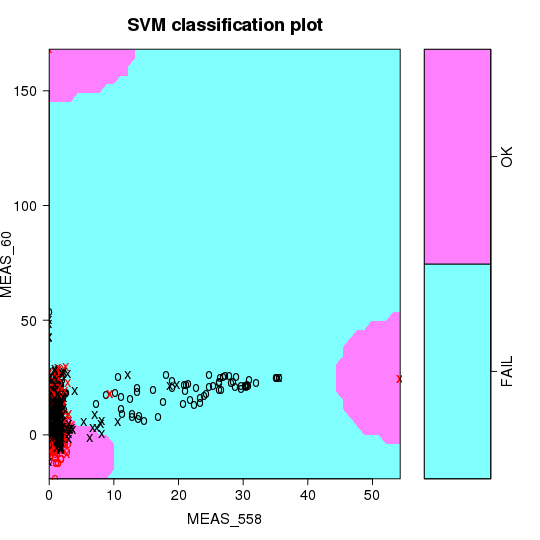

In [451]:
plot(fit.svm,data=secom.train,MEAS_60 ~ MEAS_558)

While looking at this plot, remember that our "positive" class is FAIL. You should seeing them als black points. WHere the X indicate the support vectors.

### Looking at a better SVM plot
Of course, there are datasets that allow them selves to be classified much better with SVM. Consider the example below, which is based on the Iris dataset.

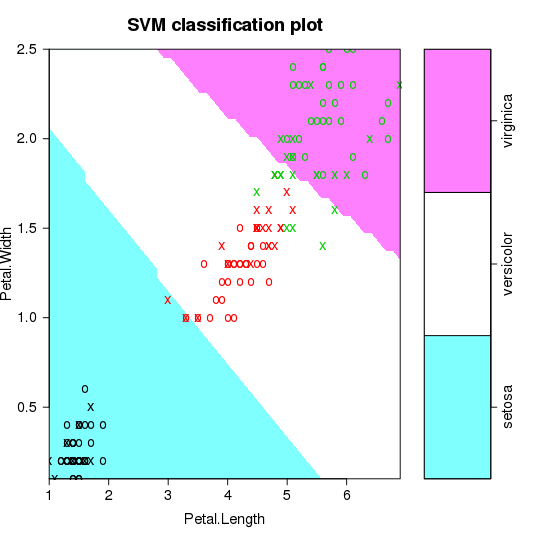

In [453]:
data(iris)

iris.svm <- svm(Species ~ ., data = iris)
plot(iris.svm, iris, Petal.Width ~ Petal.Length, slice = list(Sepal.Width = 3, 
    Sepal.Length = 4))